# **IMPORT PACKAGE**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

# **READ DATASET**
Disini kita menggunakan 2 sample dataset yaitu data set histori user dan data set proyek


In [2]:
interactings = pd.read_csv("/content/histori.csv")

In [3]:
interactings.sample(5)

,id_user,id_proyek,interacted
64902,824,96905,1
63988,812,74339,1
50459,649,81534,1
39746,510,1909,1
32693,425,638,1


In [4]:
tabel_proyek = pd.read_csv("/content/tabProyek_100k.csv")

In [5]:
tabel_proyek.head()

,id_proyek,tag_1,tag_2,tag_3,tag_4,tag_5
0,1,Travel,Design,Communication,Social,Science
1,2,Photography,Beauty,Environment,Travel,Books
2,3,Tools,Social,Video,Creativity,Audio
3,4,Video,Environment,Health,Fashion,Sports
4,5,Drink,Food,Photography,Sports,Productivity


# **PREPROCESSING**
Disini kita akan mencari labels feature yaitu item yang sudah pernah di interaksi dengan user dengan menggunakan data set yang sudah ada kita hanya perlu mencari item item yang belum pernah di "klik" oleh user

In [6]:
all_idProyek = tabel_proyek['id_proyek'].unique()

users, items, labels = [], [], []

user_item_set = set(zip(interactings['id_user'], interactings['id_proyek']))

num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # user yang sudah berinteraksi dengan item merupakan positif number (1)
    for _ in range(num_negatives):
        # memilih item secara random
        negative_item = np.random.choice(all_idProyek) 
        # cek apakah user belum berinteraksi dengan item proyek
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_idProyek)
        users.append(u)
        items.append(negative_item)
        labels.append(0) #  item yang belum berinteraksi merupakan negatif number (0)

100%|██████████| 78921/78921 [00:06<00:00, 12989.49it/s]


In [7]:
print(len(interactings['id_user']))
print(len(interactings['id_proyek']))
print(len(users))
print(len(labels))
print(len(all_idProyek))

78921
78921
394605
394605
100000


# **SPLIT DATA**
Selanjutnya kita akan memisahkan data training dan data testing untuk keperluan membangun model kita nanti

untuk input data X merupakan variable id_user dan juga id_item
dan untuk label y dimana ini akan dijadikan feature untuk model kita adalah merupakan nilai interaksi antara user dan item dengan 1 merupakan item yang sudah pernah interaksi dengan user dan 0 item yang belum pernah interaksi dengan user

In [8]:
train_user_data = np.array(users)
train_project_data = np.array(items)
train_labels = np.array(labels)


In [9]:
X = np.column_stack((train_user_data, train_project_data))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.3, random_state=42)


In [11]:
print("Training data size:", len(X_train))
print("Testing data size:", len(X_test))

Training data size: 276223
Testing data size: 118382


In [12]:
print(X_train)
print(X_test)

[[  289 69472]
 [  483 67817]
 [  966 77444]
 ...
 [  339 96330]
 [  563 14811]
 [    8 12645]]
[[   79 28204]
 [   90 28190]
 [  394 51319]
 ...
 [  205 54585]
 [  399 78521]
 [  687 46395]]


In [13]:
print(X_train[:, 0])
print(X_train[:, 1])

print(X_test[:, 0])
print(X_test[:, 1])

[289 483 966 ... 339 563   8]
[69472 67817 77444 ... 96330 14811 12645]
[ 79  90 394 ... 205 399 687]
[28204 28190 51319 ... 54585 78521 46395]


In [14]:
num_users = len(users)
num_items = len(items)

print(num_users)
print(num_items)

394605
394605


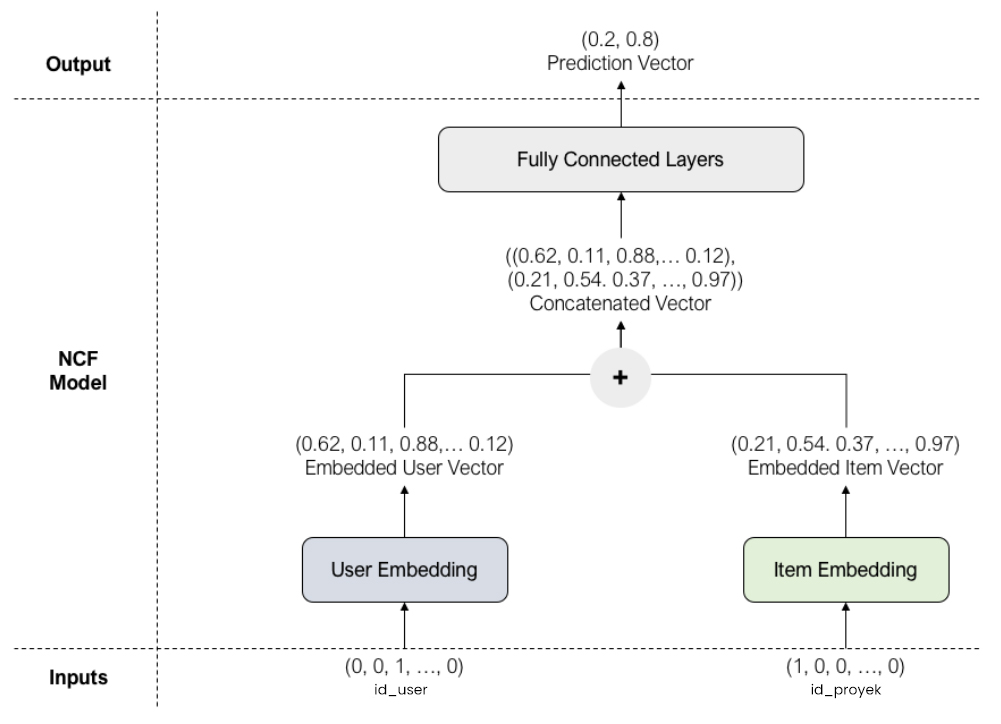

# **MODEL ARCHITECTURE**
Disini kita akan menggunakan model Neural Collaborative Filtering (NCF)
Input untuk model ini yaitu vector item dari id_user dan id_proyek dan true label adalah interacted antara user dan item

In [15]:
user_input = tf.keras.Input(shape=(1,), name='user_input')
item_input = tf.keras.Input(shape=(1,), name='item_input')

In [16]:
embedding_dim = 32

user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim)(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim)(item_input)

user_flatten = Flatten()(user_embedding)
item_flatten = Flatten()(item_embedding)

concat = Concatenate()([user_flatten, item_flatten])

hidden_units = [256, 128, 64, 32, 16]

for units in hidden_units:
    concat = Dense(units, activation='relu')(concat)

output = Dense(1, activation='sigmoid')(concat)

In [17]:
model = Model(inputs=[user_input, item_input], outputs=output)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [20]:
model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=5, batch_size=64)

Epoch 1/5
4316/4316 [==============================] - 2380s 551ms/step - loss: 0.5014 - accuracy: 0.8001
Epoch 2/5
4316/4316 [==============================] - 2370s 549ms/step - loss: 0.5014 - accuracy: 0.8001
Epoch 3/5
4316/4316 [==============================] - 2355s 546ms/step - loss: 0.5015 - accuracy: 0.8001
Epoch 4/5
4316/4316 [==============================] - 2396s 555ms/step - loss: 0.5016 - accuracy: 0.8001
Epoch 5/5
4316/4316 [==============================] - 2459s 570ms/step - loss: 0.5014 - accuracy: 0.8001


In [22]:
accuracy = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)[1]
print("Accuracy:", accuracy)

3700/3700 [==============================] - 9s 2ms/step - loss: 0.5036 - accuracy: 0.7998
Accuracy: 0.7997921705245972


setelah kita evaluasi model nya didapat accuracy 0.79 dan nilai loss 0.5 angka yang cukup baik untuk dijadikan suatu model

# **RECOMMENDER**
Selanjutnya kita akan membangun sebuah sistem rekomendasi berdasarkan interaksi antara user dan item

Kuncinya di sini adalah kita tidak perlu pengguna berinteraksi dengan setiap item dalam daftar rekomendasi. Sebaliknya, kita hanya perlu pengguna berinteraksi dengan setidaknya satu item dalam daftar tersebut - selama pengguna melakukannya, rekomendasi telah berhasil.

Untuk mensimulasikan ini, jalankan protokol evaluasi berikut untuk menghasilkan daftar 10 item rekomendasi untuk setiap pengguna.

- Untuk setiap pengguna, secara acak pilih 99 item yang **belum pernah** berinteraksi dengan user.
- Gabungkan 99 item ini dengan item test (item yang sebenarnya yang berinteraksi dengan user). Sekarang kita memiliki 100 item.
- Jalankan model pada 100 item ini, dan urutkan mereka berdasarkan probabilitas prediksi mereka.
- Pilih 10 item teratas dari daftar 100 item. Jika item test berada di antara 10 item teratas, maka kita katakan bahwa ini adalah hit.
- Ulangi proses ini untuk semua pengguna. Hit Ratio adalah rata-rata hit.



In [23]:
# Pasangan User-item untuk testing
test_user_item_set = set(zip(X_test[:, 0], X_test[:, 1]))

#daftar semua item yang sudah berinteraksi dengan setiap user
user_interacted_items = interactings.groupby('id_user')['id_proyek'].apply(list).to_dict()
hits = []
recommendations = {}
for (u, i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_idProyek).difference(set(interacted_items))
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    # TensorFlow tensors untuk user dan test item
    u_tensor = tf.convert_to_tensor([u] * 100, dtype=tf.int32)
    test_items_tensor = tf.convert_to_tensor(test_items, dtype=tf.int32)
    
    # Meneruskan proses ke model yang telah kita buat
    predicted_label = model([u_tensor, test_items_tensor])
    predicted_labels = tf.squeeze(predicted_label).numpy()
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][:10]]

    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)

    recommendations[u] = top10_items

print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

100%|██████████| 118331/118331 [1:14:02<00:00, 26.64it/s]

The Hit Ratio @ 10 is 1.00


In [24]:
for u, rec_project in recommendations.items():
    print("User", u, "recommended proyeks:", rec_project)

User 817 recommended proyeks: [59270, 34061, 49925, 95924, 47936, 2896, 37244, 14078, 61520, 38297]
User 380 recommended proyeks: [87310, 39807, 42391, 84792, 77732, 78000, 65563, 75991, 25061, 26717]
User 56 recommended proyeks: [12377, 15485, 51575, 42885, 60302, 14020, 65720, 46935, 71457, 4100]
User 321 recommended proyeks: [11250, 12223, 56202, 57016, 53317, 71873, 46546, 72482, 83072, 45311]
User 942 recommended proyeks: [65325, 17938, 11400, 43167, 11461, 25952, 68592, 19102, 23373, 36374]
User 205 recommended proyeks: [99934, 69030, 59859, 60043, 64761, 68965, 25117, 45952, 32196, 41403]
User 193 recommended proyeks: [31090, 53910, 88307, 87039, 97151, 69246, 68954, 59623, 35754, 92574]
User 177 recommended proyeks: [85111, 6071, 4765, 69163, 78661, 29450, 85311, 13827, 39023, 16025]
User 476 recommended proyeks: [5876, 19885, 87095, 44217, 53983, 72329, 86266, 11597, 17938, 80811]
User 557 recommended proyeks: [45358, 72391, 93215, 53361, 10031, 68873, 8256, 7062, 10549, 30489

Membuat recommendasi dengan spesifik user

In [25]:
specific_user = int(input("Masukan id_user = "))
if specific_user in recommendations:
    recommended_items = recommendations[specific_user]
    print("Rekomendasi proyek untuk user", specific_user, ":", recommended_items)
else:
    print("Belum ada interaksi antara user", specific_user, "dengan proyek manapun")

Masukan id_user = 324
Rekomendasi proyek untuk user 324 : [90555, 49473, 25841, 76904, 67265, 17737, 88539, 17585, 47820, 44719]


Membuat Rekomendasi dengan user yang benar benar baru membuat akun yang tidak memiliki histori interaksi sama sekali dengan menggunakan metode **cold-start recommendations** yaitu dengan membuat general rekomendasi untuk semua user berdasarkan keseluruhan popularitas

In [26]:
item_popularity = interactings['id_proyek'].value_counts().sort_values(ascending=False)

top10_popular_items = item_popularity.index[:10].tolist()

recommendations = top10_popular_items

print("Rekomendasi id_proyek untuk user baru:")
for item in recommendations:
    print(item)


Rekomendasi id_proyek untuk user baru:
47057
15254
15358
89270
42483
66613
17569
86574
16286
6568


In [31]:
from google.colab import files

model.save('model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
#Save the trained model as a Keras HDF5 file. 
saved_model_path = "./my_model.h5"
model.save(saved_model_path)

In [33]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)